In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from os import listdir

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!unzip -uq "/content/drive/My Drive/datasets/FER_2013.zip" -d "/content/drive/My Drive/datasets"

## Load dataset

In [5]:
dataset = pd.read_csv("/content/drive/My Drive/datasets/FER_2013/fer2013.csv")

In [6]:
dataset.shape

(35887, 3)

In [7]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [40]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
labels = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

In [9]:
dataset['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [10]:
print(dataset.columns)

Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [11]:
dataset.shape

(35887, 3)

In [12]:
del(dataset['Usage'])
dataset.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


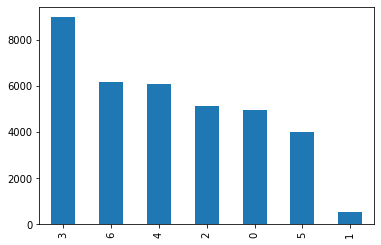

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

mapping_emotion = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutral': 6, 'sadness': 4, 'surprise': 5}

view_data = dataset

dataset['emotion'].value_counts().plot(kind='bar')

<BarContainer object of 7 artists>

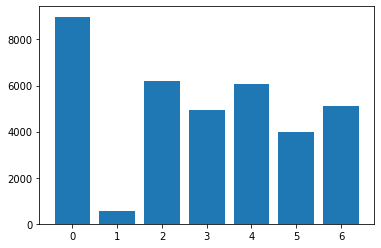

In [14]:
plt.bar(view_data['emotion'].unique(),dataset['emotion'].value_counts())

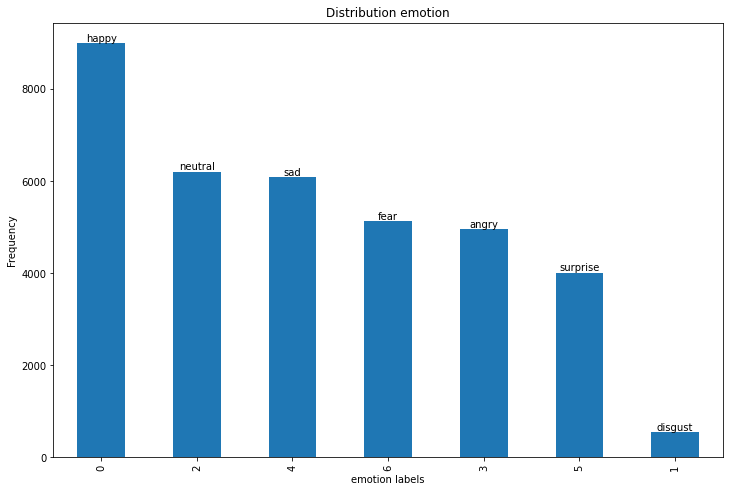

In [15]:
# Plot the figure.
plt.figure(figsize=(12, 8))
ax = dataset['emotion'].value_counts().plot(kind='bar')
ax.set_title('Distribution emotion')
ax.set_xlabel('emotion labels')
ax.set_ylabel('Frequency')
ax.set_xticklabels(dataset['emotion'].unique())

rects = ax.patches

# Make some labels.
labels_emotion = ['happy','neutral', 'sad', 'fear', 'angry', 'surprise','disgust'  ]

for rect, label in zip(rects, labels_emotion):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
    
fig = ax.get_figure()
fig.savefig('/content/drive/My Drive/emotion_bar.png')

## Define function to add data to FER2013

In [16]:
legend_of_images = pd.read_csv("/content/drive/My Drive/datasets/FER_2013/legend.csv")

In [17]:
legend_of_images.head()

,user.id,image,emotion
0,628,facial-expressions_2868588k.jpg,anger
1,628,facial-expressions_2868585k.jpg,surprise
2,628,facial-expressions_2868584k.jpg,disgust
3,628,facial-expressions_2868582k.jpg,fear
4,dwdii,Aaron_Eckhart_0001.jpg,neutral


In [18]:
legend_of_images.emotion.unique()

array(['anger', 'surprise', 'disgust', 'fear', 'neutral', 'happiness',
       'sadness', 'contempt', 'NEUTRAL', 'SADNESS', 'DISGUST', 'FEAR',
       'SURPRISE', 'ANGER', 'HAPPINESS'], dtype=object)

In [19]:
#0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
def get_labels(filename):
    res = legend_of_images[legend_of_images['image'] == filename]['emotion']
    res = np.array(res)
    print(res,res.shape)
    emotion = " "
    if len(res) != 0 :
        emotion=res[-1]
    else:
        return -1
    print('E: ',type(emotion))
    if emotion.lower() == 'anger':
        return 0
    elif emotion.lower() == 'happiness' or emotion.lower() == 'contempt':
        return 3
    elif emotion.lower() == 'disgust':
        return 1
    elif emotion.lower() == 'fear':
        return 2
    elif emotion.lower() == 'neutral':
        return 6
    elif emotion.lower() == 'sadness':
        return 4
    elif emotion.lower() == 'surprise':
        return 5
    else :
        return -1
    

In [20]:
# image resize

def image_resize(path):
    img = tf.keras.preprocessing.image.load_img(path, grayscale=True, color_mode='rgb', target_size=(48, 48),interpolation='nearest')
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img = img_arr.reshape(48,48)
    img = np.array(img)
    print(img_arr.shape)
    return img

def load_datasets(dataset_directory, emotion_dataset_x, emotion_dataset_y):
    a = 0
    #get path
    path_folder = dataset_directory + '/'
    files = []
    _labels = []
    for filename in listdir(dataset_directory):
        #img = cv2.imread(path_folder+filename)
        img = image_resize(path_folder+filename)
        a = get_labels(filename)
        if a != -1:
            emotion_dataset_x.append(img)
            emotion_dataset_y.append(a)
            files.append(img)
            _labels.append(a)
            
    return emotion_dataset_x,emotion_dataset_y, files, _labels

## ## reshape each pixels into (48, 48) 

In [21]:
emotion_dataset_x = []
emotion_dataset_y = []
for data in dataset.values:
    emotion_dataset_y.append(data[0])
    emotion_dataset_x.append(np.array(data[1].split(' '), dtype='float32').reshape(48,48))
    

dir = '/content/drive/My Drive/datasets/FER_2013/images/'
emotion_dataset_x, emotion_dataset_y, add_images, add_labels = load_datasets(dir, emotion_dataset_x, emotion_dataset_y)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
['SADNESS'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['happiness'] (1,)
E:  <class 'str'>
(48, 48, 1)
['happiness'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['happiness'] (1,)
E:  <class 'str'>
(48, 48, 1)
['happiness'] (1,)
E:  <class 'str'>
(48, 48, 1)
['happiness'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1,)
E:  <class 'str'>
(48, 48, 1)
['happiness'] (1,)
E:  <class 'str'>
(48, 48, 1)
['surprise'] (1,)
E:  <class 'str'>
(48, 48, 1)
['happiness'] (1,)
E:  <class 'str'>
(48, 48, 1)
['neutral'] (1

In [22]:
print("Images add to FER2013", np.array(add_images).shape, np.array(add_labels).shape)

Images add to FER2013 (13682, 48, 48) (13682,)


(49569, 48, 48) (49569,)


numpy.ndarray

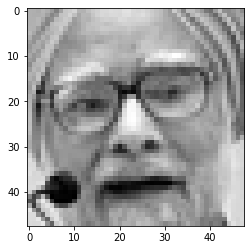

In [23]:
## transform to array

emotion_dataset_x = np.array(emotion_dataset_x)
emotion_dataset_y = np.array(emotion_dataset_y)

print(emotion_dataset_x.shape, emotion_dataset_y.shape)

#for i in range(len(emotion_dataset_x)):
    #plt.imsave("FER_2013/toto_" + str(i) +".png",emotion_dataset_x[i], cmap="gray")
#plt.imsave("FER_2103/toto.png",emotion_dataset_x[1], cmap="gray")
plt.imshow(emotion_dataset_x[1], cmap="gray")
type(emotion_dataset_x[36000])

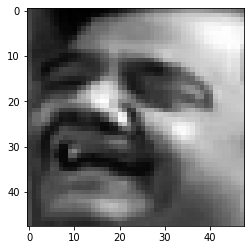

In [24]:
plt.imshow(emotion_dataset_x[46666], cmap="gray")

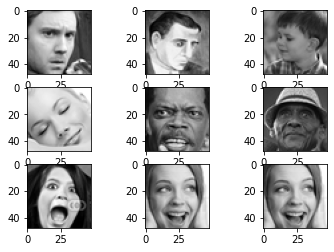

In [25]:
fig,a =  plt.subplots(3,3)

a[0][0].imshow(emotion_dataset_x[0], cmap="gray")
a[0][1].imshow(emotion_dataset_x[466], cmap="gray")
a[0][2].imshow(emotion_dataset_x[66], cmap="gray")
a[1][0].imshow(emotion_dataset_x[666], cmap="gray")
a[1][1].imshow(emotion_dataset_x[10], cmap="gray")
a[1][2].imshow(emotion_dataset_x[4666], cmap="gray")
a[2][0].imshow(emotion_dataset_x[660], cmap="gray")
a[2][1].imshow(emotion_dataset_x[6666], cmap="gray")
a[2][2].imshow(emotion_dataset_x[6666], cmap="gray")
plt.show()

fig.savefig('/content/drive/My Drive/emotion_data.png')

## split dataset into train , validation and test sets

In [26]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(emotion_dataset_x, emotion_dataset_y, train_size=0.8, test_size=0.2, random_state=101)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, test_size=0.2, random_state=101)

In [27]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)
len(x_train)

(31724, 48, 48) (31724,) (9914, 48, 48) (9914,) (7931, 48, 48) (7931,)


31724

## Create Model

In [28]:
len(labels)

7

In [29]:
 model2 = tf.keras.Sequential([
    #1st convolution layer
    tf.keras.layers.Conv2D(64, (5, 5), activation=tf.nn.relu, input_shape=(48,48,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2)),
    #2nd convolution layer
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2)),
    #3rd convolution layer
    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.Conv2D(128, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2)),

    tf.keras.layers.Flatten(),

    #fully connected neural networks
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),

    tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    
    ])

In [30]:
inputShape = (48, 48, 1)
chanDim = -1
# if we are using "channels first", update the input shape
# and channels dimension
if K.image_data_format() == "channels_first":
    inputShape = (1, 48, 48)
    chanDim = 1
model = tf.keras.Sequential([ 
    
     tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation=tf.nn.relu, input_shape=inputShape),
     tf.keras.layers.BatchNormalization(axis=chanDim),
     tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
     tf.keras.layers.Dropout(0.25),

    
     tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation=tf.nn.relu),
     tf.keras.layers.BatchNormalization(axis=chanDim),
     tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation=tf.nn.relu),
     tf.keras.layers.BatchNormalization(axis=chanDim),
     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     tf.keras.layers.Dropout(0.25),

     
     tf.keras.layers.Conv2D(128, (3, 3), padding="same",activation=tf.nn.relu),
     tf.keras.layers.BatchNormalization(axis=chanDim),
     tf.keras.layers.Conv2D(128, (3, 3), padding="same",activation=tf.nn.relu),
     tf.keras.layers.BatchNormalization(axis=chanDim),
     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
     tf.keras.layers.Dropout(0.25),

     tf.keras.layers.Flatten(),

     #fully connected neural networks
     tf.keras.layers.Dense(1024, activation=tf.nn.relu),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.25),


     tf.keras.layers.Dense(1024, activation=tf.nn.relu),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.25),

     tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
])

In [31]:
# set batch size and epoch
epochs = 100
INIT_LR = 1e-3
batch_size = 64

In [32]:
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')
x_val = x_val.reshape(x_val.shape[0], 48, 48, 1)
x_val = x_val.astype('float32')

from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

train_size = len(x_train)

In [33]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = generator.flow(x_train, y_train, batch_size=batch_size)
val_generator = generator.flow(x_val, y_val, batch_size=batch_size)

opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / epochs)

model.compile(loss='categorical_crossentropy'
, optimizer=opt
, metrics=['accuracy']
)

#model.load_weights("facial_expression_model_weights.h5")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 23, 23, 64)       

## Fit Model

In [34]:
histories = model.fit(train_generator,validation_data=val_generator, steps_per_epoch=train_size//batch_size, epochs=epochs, validation_steps = (len(x_val))//batch_size)

Epoch 1/100
495/495 [==============================] - 6s 13ms/step - loss: 1.7185 - accuracy: 0.4226 - val_loss: 1.4920 - val_accuracy: 0.4703
Epoch 2/100
495/495 [==============================] - 6s 13ms/step - loss: 1.3079 - accuracy: 0.5391 - val_loss: 1.2836 - val_accuracy: 0.5497
Epoch 3/100
495/495 [==============================] - 6s 13ms/step - loss: 1.1994 - accuracy: 0.5771 - val_loss: 1.3157 - val_accuracy: 0.5761
Epoch 4/100
495/495 [==============================] - 6s 13ms/step - loss: 1.1220 - accuracy: 0.6021 - val_loss: 1.1587 - val_accuracy: 0.5752
Epoch 5/100
495/495 [==============================] - 6s 13ms/step - loss: 1.0530 - accuracy: 0.6242 - val_loss: 1.1267 - val_accuracy: 0.5991
Epoch 6/100
495/495 [==============================] - 6s 13ms/step - loss: 0.9867 - accuracy: 0.6423 - val_loss: 1.1536 - val_accuracy: 0.5945
Epoch 7/100
495/495 [==============================] - 6s 13ms/step - loss: 0.9333 - accuracy: 0.6579 - val_loss: 1.0560 - val_accuracy:

# Model evaluate

In [36]:
x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 3.2479407787323
Train accuracy: 10.525154322385788
Test loss: 3.273314952850342
Test accuracy: 10.106919705867767


### Save Model

In [43]:
model.save("/content/drive/My Drive/models/ER_100_64_97_93.h5", save_format="h5")

In [44]:
histories.history

{'accuracy': [0.42261528968811035,
  0.5390713810920715,
  0.5770688652992249,
  0.6020846366882324,
  0.6241945624351501,
  0.6422930955886841,
  0.6578648090362549,
  0.6768161654472351,
  0.6907770037651062,
  0.7036323547363281,
  0.7265635132789612,
  0.7425773739814758,
  0.7592545747756958,
  0.7793430089950562,
  0.7949779033660889,
  0.8119709491729736,
  0.8225205540657043,
  0.8339545130729675,
  0.8491156101226807,
  0.8617182374000549,
  0.8751737475395203,
  0.883417546749115,
  0.8844283223152161,
  0.8931775093078613,
  0.9023057222366333,
  0.9096020460128784,
  0.9117182493209839,
  0.9149084091186523,
  0.9171509742736816,
  0.9212570786476135,
  0.9237207770347595,
  0.9278268814086914,
  0.9356917142868042,
  0.9340176582336426,
  0.9354390501976013,
  0.9346809983253479,
  0.9402084946632385,
  0.9429563879966736,
  0.9476310610771179,
  0.9470625519752502,
  0.9489260911941528,
  0.9492103457450867,
  0.9465887546539307,
  0.9487365484237671,
  0.9543904066085815

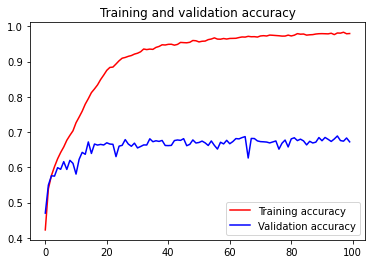

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.pyplot as plt

acc = histories.history['accuracy']
val_acc = histories.history['val_accuracy']
loss = histories.history['loss']
val_loss = histories.history['val_loss']
#prec = histories.history['precision']
#val_prec = histories.history['val_precision']
#recall = histories.history['recall']
#val_recall = histories.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig("/content/drive/My Drive/reports/train_val_acc_100_epochs_batch_64.png")

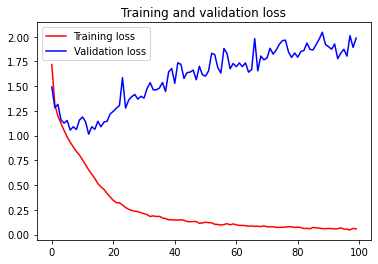

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [56]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()
plt.savefig("/content/drive/My Drive/reports/100train_val_loss_100_epochs_batch_64.png")

In [49]:
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()
    plt.savefig("/content/drive/My Drive/reports/100_epochs_batch_64/img_pred_100_epochs_batch_64x2.png")

In [50]:
#resize_imge = 800
def frame_image(img):
   
    hist,bins = np.histogram(img.flatten(),256,[0,256])

    cdf = hist.cumsum()
   
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    
    img = cdf[img]
   
    return img

In [51]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 4.7MB/s 


In [52]:
from mtcnn.mtcnn import MTCNN

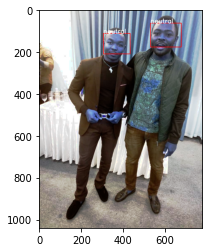

In [53]:

img = cv2.imread("/content/drive/My Drive/datasets/01.jpg")

detector = MTCNN()


frame = frame_image(img)
# detect faces in the image
faces = detector.detect_faces(frame)

for face in faces:

    x, y, h, w = face['box']
    # gray_face = gray_image[h:w, x:y]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    detected_face = frame[int(y):int(y+h), int(x):int(x+w)] #crop detected face
    detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
    detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48
    
    img_pixels = np.array(detected_face)
    img_pixels = np.expand_dims(img_pixels, axis = 0)
    img_pixels = img_pixels.reshape(img_pixels.shape[0], 48, 48, 1)
    img_pixels = img_pixels.astype('float32')
      
    img_pixels /= 255
      
    predictions = model.predict(img_pixels)
      
    #find max indexed array
    max_index = np.argmax(predictions[0])
      
    emotion = labels[max_index]
      
    cv2.putText(frame, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    plt.imshow(frame,cmap='gray')
    cv2.imwrite("/content/drive/My Drive/reports/img_emotion-{}.jpg".format(np.random.randint(0,1000)), frame)

cv2.destroyAllWindows()


In [54]:
#!pip install mtcnn
from mtcnn.mtcnn import MTCNN

#VIDEO_PATH = "/content/drive/My Drive/datasets/01.jpg"
cap = cv2.VideoCapture(0)

detector = MTCNN()

while cap.isOpened(): # True:
    ret, frame = cap.read()
    frame = p.frame_image(frame)
    # detect faces in the image
    faces = detector.detect_faces(frame)

    for face in faces:

        x, y, h, w = face['box']
       # gray_face = gray_image[h:w, x:y]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        detected_face = frame[int(y):int(y+h), int(x):int(x+w)] #crop detected face
        detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
        detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
         
        img_pixels /= 255
         
        predictions = model.predict(img_pixels)
         
        #find max indexed array
        max_index = np.argmax(predictions[0])
         
        emotion = labels[max_index]
         
        cv2.putText(frame, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
        cv2.imshow('window_frame', frame)
        cv2.imwrite("/content/drive/My Drive/reports/img_emotion-{}.jpg".format(np.random.randint(0,1000)), frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
